In [7]:
import os

In [1]:
import pandas as pd
import numpy as np
import pickle

In [70]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()

In [71]:
from datetime import datetime

In [90]:
from math import sqrt

In [72]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
from sklearn.model_selection import (cross_val_score, cross_val_predict, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [84]:
import xgboost as xgb

# The goal is to predict departing flights that will be delayed. A flight is considered delay when it takes more than 15 minutes to leave the gate. 

Within the delta dataframe, there is a column called departure delay that points out how early or late the flight was from the scheduled departure time in minutes. Using this, I calculated the target column named 'Departure Delay' which dictates that any flight that took longer than 15 minutes to depart is considered to be delay (1) and 15 minutes or less is considered to be on-time (0). 

Because Delta wants to make actionable decisions based on this model, it's essential for it to be as precise as possible. The secondary priority is to increase recall so that they are able to mitigate the damages of as many flight delays as possible. 

In [16]:
selection = 25
year = '2019'
airline = 'DL'
download_path = r'/home/desbrium/Metis/PredictingFlightDelays/Data/BTS Departure Data'
file_path = os.path.join(download_path, f'{selection}airports{airline}{year}.csv')

In [17]:
delta_df = pd.read_csv(file_path)

In [18]:
delta_df.head()

,Unique_Id,Carrier Code,Flight Date,Flight Number,Month,Tail Number,Origin Airport,Origin City,Origin State,Origin Divison,...,Cancelled,Diverted,Flights,Distance,Distance Name,Distance Range Name,Scheduled Arrival Time,Actual Arrival Time,Minutes Delayed Arriving,AirTime
0,01/01/2019-N67171-15-ATL,DL,2019-01-01,15,January,N67171,ATL,Atlanta,Georgia,South Atlantic,...,0.0,0.0,1.0,406.0,Short Haul,90-583,2119,2108.0,-11.0,64.0
1,01/01/2019-N354NW-31-ATL,DL,2019-01-01,31,January,N354NW,ATL,Atlanta,Georgia,South Atlantic,...,0.0,0.0,1.0,731.0,Short Haul,583-1072,2042,2036.0,-6.0,112.0
2,01/01/2019-N960DL-91-ATL,DL,2019-01-01,91,January,N960DL,ATL,Atlanta,Georgia,South Atlantic,...,0.0,0.0,1.0,515.0,Short Haul,90-583,1905,1859.0,-46.0,86.0
3,01/01/2019-N944AT-131-ATL,DL,2019-01-01,131,January,N944AT,ATL,Atlanta,Georgia,South Atlantic,...,0.0,0.0,1.0,153.0,Short Haul,90-583,1840,1832.0,-8.0,31.0
4,01/01/2019-N173DZ-186-ATL,DL,2019-01-01,186,January,N173DZ,ATL,Atlanta,Georgia,South Atlantic,...,0.0,0.0,1.0,404.0,Short Haul,90-583,1725,1717.0,-8.0,60.0


In [19]:
delta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704501 entries, 0 to 704500
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unique_Id                        704501 non-null  object 
 1   Carrier Code                     704501 non-null  object 
 2   Flight Date                      704501 non-null  object 
 3   Flight Number                    704501 non-null  int64  
 4   Month                            704501 non-null  object 
 5   Tail Number                      704500 non-null  object 
 6   Origin Airport                   704501 non-null  object 
 7   Origin City                      704501 non-null  object 
 8   Origin State                     704501 non-null  object 
 9   Origin Divison                   704501 non-null  object 
 10  Origin Region                    704501 non-null  object 
 11  Dest Airport                     704501 non-null  object 
 12  De

In [20]:
delta_df.columns

Index(['Unique_Id', 'Carrier Code', 'Flight Date', 'Flight Number', 'Month',
       'Tail Number', 'Origin Airport', 'Origin City', 'Origin State',
       'Origin Divison', 'Origin Region', 'Dest Airport', 'Dest City',
       'Dest State', 'Dest Divison', 'Dest Region', 'Scheduled Departure Time',
       'Actual Departure Time', 'Actual Departure Time Name',
       'Minutes Delayed Departing', 'Delayed Departure',
       'Scheduled Elapsed Time', 'Actual Elapsed Time', 'Wheels-off Time',
       'Taxi-out Time', 'Minutes Delayed By Carrier',
       'Minutes Delayed By Weather', 'Minutes Delayed By NAS',
       'Minutes Delayed By Security', 'Minutes Delayed By Late Arrival',
       'Cancelled', 'Diverted', 'Flights', 'Distance', 'Distance Name',
       'Distance Range Name', 'Scheduled Arrival Time', 'Actual Arrival Time',
       'Minutes Delayed Arriving', 'AirTime'],
      dtype='object')

In [21]:
delta_df_features = delta_df[['Origin Airport', 'Origin Region', 'Actual Departure Time Name',
       'Distance Range Name', 'Minutes Delayed By Carrier',
       'Minutes Delayed By Weather', 'Minutes Delayed By NAS',
       'Minutes Delayed By Security', 'Minutes Delayed By Late Arrival',
        ]]

In [23]:
delta_df_target = delta_df['Delayed Departure']

In [24]:
delayed = delta_df_target.sum()
perc_delayed = round(delta_df_target.sum()/delta_df_target.count(),2)
print(f'Number of delayed Delta flights in 2019: {delayed}, {int(perc_delayed*100)}% were delayed')

not_delayed = delta_df_target.count() - delayed 
perc_not_delayed = 1 - perc_delayed
print(f'Number of not delayed Delta flights in 2019: {not_delayed}, {int(perc_not_delayed*100)}% were not delayed')

Number of delayed Delta flights in 2019: 105882, 15% were delayed
Number of not delayed Delta flights in 2019: -105881, 85% were not delayed


In [25]:
positive_class = perc_delayed

positive_class

0.15

In [26]:
negative_class = perc_not_delayed

negative_class

0.85

In [27]:
delta_df[['Minutes Delayed By Carrier',
       'Minutes Delayed By Weather', 'Minutes Delayed By NAS',
       'Minutes Delayed By Security', 'Minutes Delayed By Late Arrival'
        ]].describe()

,Minutes Delayed By Carrier,Minutes Delayed By Weather,Minutes Delayed By NAS,Minutes Delayed By Security,Minutes Delayed By Late Arrival
count,704501.000000,704501.000000,704501.000000,704501.000000,704501.000000
mean,3.632091,0.728494,3.060468,0.010633,2.948092
std,27.429235,15.664364,19.666613,1.034018,18.858401
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1265.000000,1167.000000,1215.000000,434.000000,1046.000000


Delay Carrier, National Aviation System, and Late Aircraft Arrival looks like good predictors of departure delays

# Baseline Logistic Regression

No scaler needed for this because the features are all on the same scale as shown in the describe table. Definitely need to stratify this

In [29]:
X = delta_df[['Minutes Delayed By Carrier', 'Minutes Delayed By NAS','Minutes Delayed By Late Arrival']]

In [30]:
y = delta_df['Delayed Departure'] 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)

In [37]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [ ]:
#stratifykhold

In [38]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
lr = LogisticRegression(C=1000)

In [40]:
lr.fit(X_train2, y_train2)

LogisticRegression(C=1000)

In [41]:
lr.score(X_train2, y_train2)

0.9437544357700497

In [42]:
lr.coef_, lr.intercept_

(array([[0.2451373 , 0.04484369, 0.27993727]]), array([-3.03233378]))

In [43]:
y_val_pred = lr.predict(X_val)

In [44]:
cross_val_score(lr, X_train2, y_train2, cv=kfold)

array([0.94356592, 0.9441093 , 0.94373226, 0.94251242, 0.94490774])

In [45]:
print(f'recall_score:{recall_score(y_val, y_val_pred)}')
print(f'precision_score:{precision_score(y_val, y_val_pred)}')
print(f'accuracy_score:{accuracy_score(y_val, y_val_pred)}')
print(f'f1_score:{f1_score(y_val, y_val_pred)}')
print(f'roc_auc_score:{roc_auc_score(y_val, y_val_pred)}')

recall_score:0.6928162446136592
precision_score:0.9288540677429566
accuracy_score:0.9458569907735983
f1_score:0.7936572336612908
roc_auc_score:0.841715026743084


In [ ]:
#use logistic regression to interpret coef

In [ ]:
#class weights on dataset and feed in as parameter

In [ ]:
#beta coefficients

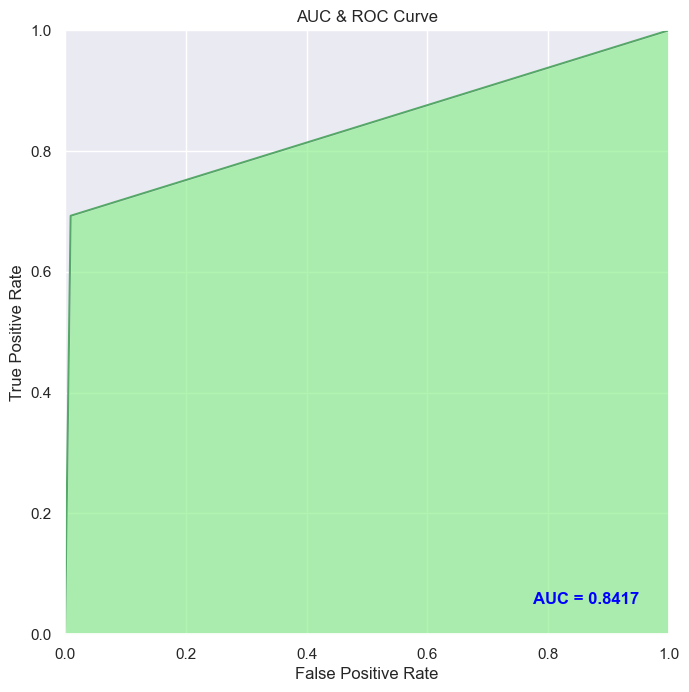

In [46]:
auc = roc_auc_score(y_val, y_val_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Baseline Random Forest

In [61]:
rf = RandomForestClassifier(n_estimators=50, max_depth=7)#, class_weight= {1: positive_class, 0: negative_class})

In [62]:
rf.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=7, n_estimators=50)

In [63]:
rf.score(X_train2, y_train2)

0.9513906139105749

In [64]:
y_val_pred = rf.predict(X_val)

In [65]:
print(f'recall_score:{recall_score(y_val, y_val_pred)}')
print(f'precision_score:{precision_score(y_val, y_val_pred)}')
print(f'accuracy_score:{accuracy_score(y_val, y_val_pred)}')
print(f'f1_score:{f1_score(y_val, y_val_pred)}')
print(f'roc_auc_score:{roc_auc_score(y_val, y_val_pred)}')

recall_score:0.7045628947523759
precision_score:0.974128784787399
accuracy_score:0.9527856635911994
f1_score:0.8177022675892306
roc_auc_score:0.8506265961039884


In [101]:
cross_val_score(rf, X_train2, y_train2, cv=kfold, scoring = 'precision')

array([0.96718147, 0.9734458 , 0.96813525, 0.96784831, 0.97470697])

<BarContainer object of 3 artists>

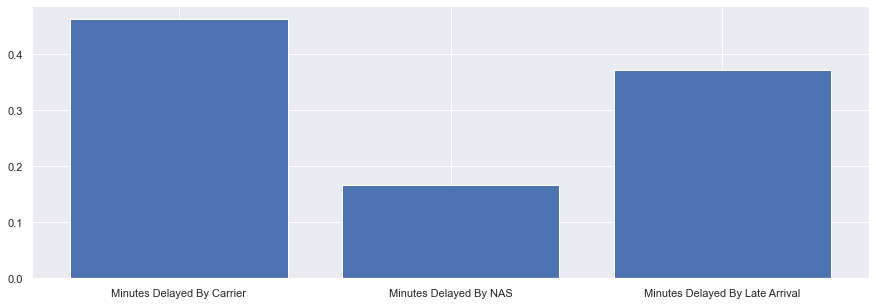

In [82]:
plt.figure(figsize=[15,5])

plt.bar(X.columns, rf.feature_importances_)

In [66]:
rf_confusion_matrix_data = {'Actual' : y_val, 'Predicted' : y_val_pred}

In [67]:
rf_confusion_matrix_df = pd.DataFrame(rf_confusion_matrix_data, columns=['Actual','Predicted'])

In [68]:
confusion_matrix = pd.crosstab(rf_confusion_matrix_df['Actual'], rf_confusion_matrix_df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [77]:
#sns.heatmap(confusion_matrix, annot=True)
#plt.show()

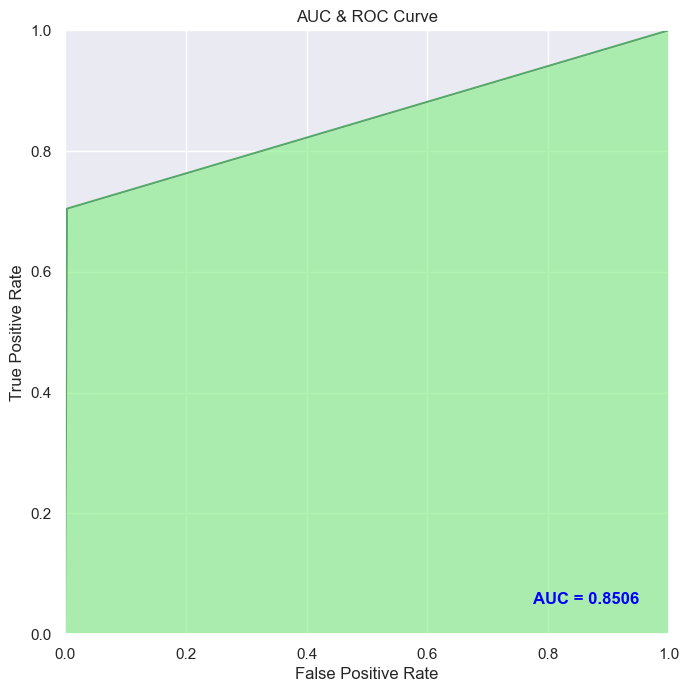

In [78]:
auc = roc_auc_score(y_val, y_val_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Baseline XGBoost

In [93]:
#use default

In [ ]:
#gridsearch

In [98]:
gbm = xgb.XGBClassifier(
                        n_estimators=100,
                        max_depth = 3,
                        learning_rate=.1, #lowering learning_rate,
                        early_stopping_rounds=20
                        )

In [100]:
cross_val_score(gbm, X_train2, y_train2, cv=kfold, scoring = 'precision')

[10:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:51] WARNING: ../src/learner.cc:1095: Starting in XGBoos

array([0.96798765, 0.96959565, 0.96941738, 0.96816811, 0.97535614])

In [86]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train2,y_train2),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train2, y_train2, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    #verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.46345	validation_1-rmse:0.46322
[1]	validation_0-rmse:0.43289	validation_1-rmse:0.43272
[2]	validation_0-rmse:0.40431	validation_1-rmse:0.40394
[3]	validation_0-rmse:0.37932	validation_1-rmse:0.37897
[4]	validation_0-rmse:0.35516	validation_1-rmse:0.35448
[5]	validation_0-rmse:0.33402	validation_1-rmse:0.33331
[6]	validation_0-rmse:0.31778	validation_1-rmse:0.31695
[7]	validation_0-rmse:0.30400	validation_1-rmse:0.30305
[8]	validation_0-rmse:0.29183	validation_1-rmse:0.29083
[9]	validation_0-rmse:0.27950	validation_1-rmse:0.27829
[10]	validation_0-rmse:0.26900	validation_1-rmse:0.26768
[11]	validation_0-rmse:0.26163	validation_1-rmse:0.26016
[12]	validation_0-rmse:0.25395	validation_1-rmse:0.25240
[13]	validation_0-rmse:0.24874	validation_1-rmse:0.24706
[14]	validation_0-rmse:0.24397	validation_1-rmse:0.24227
[15]	validation_0-rmse:0.24011	validation_1-rmse:0.23828
[16]	validation_0-rmse:0.23689	validation_1-rmse:0.23502
[17]	validation_0-rmse:0.23418	validation

In [91]:
sqrt(mean_squared_error(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test))

/home/desbrium/anaconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.2132275172850684

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

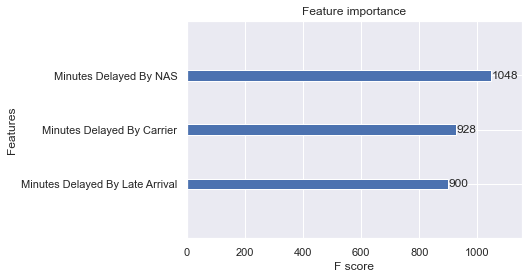

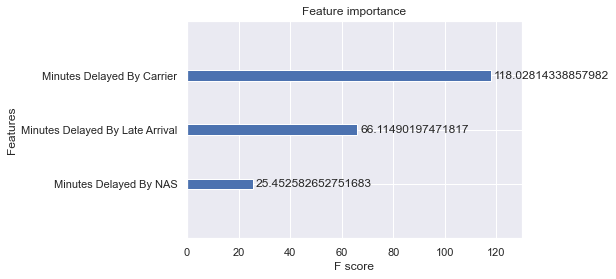

In [92]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')